Task 1

In [1]:
# !pip install -q imageio
# !pip install -q opencv-python
# !pip install -q git+https://github.com/tensorflow/docs

In [2]:
import tensorflow as tf
import tensorflow_hub as hub
#from tensorflow_docs.vis import embed
import numpy as np
import cv2
import pandas as pd

from matplotlib.collections import LineCollection
import matplotlib.patches as patches
import matplotlib.pyplot as plt

import imageio
from IPython.display import HTML, display

In [2]:
# Dictionary to map joints of body part
KEYPOINT_DICT = {
    'nose':0,
    'left_eye':1,
    'right_eye':2,
    'left_ear':3,
    'right_ear':4,
    'left_shoulder':5,
    'right_shoulder':6,
    'left_elbow':7,
    'right_elbow':8,
    'left_wrist':9,
    'right_wrist':10,
    'left_hip':11,
    'right_hip':12,
    'left_knee':13,
    'right_knee':14,
    'left_ankle':15,
    'right_ankle':16
}
# map bones to matplotlib color name
KEYPOINT_EDGE_INDS_TO_COLOR = {
    (0,1): 'm',
    (0,2): 'c',
    (1,3): 'm',
    (2,4): 'c',
    (0,5): 'm',
    (0,6): 'c',
    (5,7): 'm',
    (7,9): 'm',
    (6,8): 'c',
    (8,10): 'c',
    (5,6): 'y',
    (5,11): 'm',
    (6,12): 'c',
    (11,12): 'y',
    (11,13): 'm',
    (13,15): 'm',
    (12,14): 'c',
    (14,16): 'c'
}

def _keypoints_and_edges_for_display(keypoints_with_score,height,
                                     width,keypoint_threshold=0.11):
  """Returns high confidence keypoints and edges"""
  keypoints_all = []
  keypoint_edges_all = []
  edge_colors = []
  num_instances,_,_,_ = keypoints_with_score.shape
  for id in range(num_instances):
    kpts_x = keypoints_with_score[0,id,:,1]
    kpts_y = keypoints_with_score[0,id,:,0]
    kpts_scores = keypoints_with_score[0,id,:,2]
    kpts_abs_xy = np.stack(
        [width*np.array(kpts_x),height*np.array(kpts_y)],axis=-1)
    kpts_above_thrs_abs = kpts_abs_xy[kpts_scores > keypoint_threshold,: ]
    keypoints_all.append(kpts_above_thrs_abs)

    for edge_pair,color in KEYPOINT_EDGE_INDS_TO_COLOR.items():
      if (kpts_scores[edge_pair[0]] > keypoint_threshold and 
          kpts_scores[edge_pair[1]] > keypoint_threshold):
        x_start = kpts_abs_xy[edge_pair[0],0]
        y_start = kpts_abs_xy[edge_pair[0],1]
        x_end = kpts_abs_xy[edge_pair[1],0]
        y_end = kpts_abs_xy[edge_pair[1],1]
        lien_seg = np.array([[x_start,y_start],[x_end,y_end]])
        keypoint_edges_all.append(lien_seg)
        edge_colors.append(color)
  if keypoints_all:
    keypoints_xy = np.concatenate(keypoints_all,axis=0)
  else:
    keypoints_xy = np.zeros((0,17,2))

  if keypoint_edges_all:
    edges_xy = np.stack(keypoint_edges_all,axis=0)
  else:
    edges_xy = np.zeros((0,2,2))
  return keypoints_xy,edges_xy,edge_colors

def draw_prediction_on_image(
    image, keypoints_with_scores, crop_region=None, close_figure=False,
    output_image_height=None):
  """Draws the keypoint predictions on image"""
  height, width, channel = image.shape
  aspect_ratio = float(width) / height
  fig, ax = plt.subplots(figsize=(12 * aspect_ratio, 12))
  # To remove the huge white borders
  fig.tight_layout(pad=0)
  ax.margins(0)
  ax.set_yticklabels([])
  ax.set_xticklabels([])
  plt.axis('off')

  im = ax.imshow(image)
  line_segments = LineCollection([], linewidths=(4), linestyle='solid')
  ax.add_collection(line_segments)
  # Turn off tick labels
  scat = ax.scatter([], [], s=60, color='#FF1493', zorder=3)

  (keypoint_locs, keypoint_edges,
   edge_colors) = _keypoints_and_edges_for_display(
       keypoints_with_scores, height, width)

  line_segments.set_segments(keypoint_edges)
  line_segments.set_color(edge_colors)
  if keypoint_edges.shape[0]:
    line_segments.set_segments(keypoint_edges)
    line_segments.set_color(edge_colors)
  if keypoint_locs.shape[0]:
    scat.set_offsets(keypoint_locs)

  if crop_region is not None:
    xmin = max(crop_region['x_min'] * width, 0.0)
    ymin = max(crop_region['y_min'] * height, 0.0)
    rec_width = min(crop_region['x_max'], 0.99) * width - xmin
    rec_height = min(crop_region['y_max'], 0.99) * height - ymin
    rect = patches.Rectangle(
        (xmin,ymin),rec_width,rec_height,
        linewidth=1,edgecolor='b',facecolor='none')
    ax.add_patch(rect)

  fig.canvas.draw()
  image_from_plot = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
  image_from_plot = image_from_plot.reshape(
      fig.canvas.get_width_height()[::-1] + (3,))
  plt.close(fig)
  if output_image_height is not None:
    output_image_width = int(output_image_height / height * width)
    image_from_plot = cv2.resize(
        image_from_plot, dsize=(output_image_width, output_image_height),
         interpolation=cv2.INTER_CUBIC)
  return image_from_plot

def to_gif(images, fps):
  """Converts image sequence (4D numpy array) to gif."""
  imageio.mimsave('./animation.gif', images, fps=fps)
  return embed.embed_file('./animation.gif')

def progress(value, max=100):
  return HTML("""
      <progress
          value='{value}'
          max='{max}',
          style='width: 100%'
      >
          {value}
      </progress>
  """.format(value=value, max=max))

In [3]:
model_name = "movenet_thunder"  #["movenet_lightning", "movenet_thunder", "movenet_lightning.tflite", "movenet_thunder.tflite"]

if "tflite" in model_name:
  if "movenet_lightning" in model_name:
    !wget -q -O model.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/lightning/3?lite-format=tflite
    input_size = 192
  elif "movenet_thunder" in model_name:
    !wget -q -O model.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/thunder/3?lite-format=tflite
    input_size = 256
  else:
    raise ValueError("Unsupported model name: %s" % model_name)

  # Initialize the TFLite interpreter
  interpreter = tf.lite.Interpreter(model_path="model.tflite")
  interpreter.allocate_tensors()

  def movenet(input_image):
    """Runs detection on an input image"""
    # TF Lite format expects tensor type of float32.
    input_image = tf.cast(input_image, dtype=tf.float32)
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    interpreter.set_tensor(input_details[0]['index'], input_image.numpy())
    # Invoke inference.
    interpreter.invoke()
    # Get the model prediction.
    keypoints_with_scores = interpreter.get_tensor(output_details[0]['index'])
    return keypoints_with_scores

else:
  if "movenet_lightning" in model_name:
    module = hub.load("https://tfhub.dev/google/movenet/singlepose/lightning/3")
    input_size = 192
  elif "movenet_thunder" in model_name:
    module = hub.load("https://tfhub.dev/google/movenet/singlepose/thunder/3")
    input_size = 256
  else:
    raise ValueError("Unsupported model name: %s" % model_name)

  def movenet(input_image):
    """Runs detection on an input image"""
    model = module.signatures['serving_default']

    # SavedModel format expects tensor type of int32.
    input_image = tf.cast(input_image, dtype=tf.int32)
    # Run model inference.
    outputs = model(input_image)
    # Output is a [1, 1, 17, 3] tensor.
    keypoint_with_scores = outputs['output_0'].numpy()
    return keypoint_with_scores

In [4]:
import os
import glob
import csv
rows=[]
files=glob.glob('D:/Task/images/*')

In [5]:
for i in range(len(files)):
    basename = os.path.basename(files[i])
    img_path=files[i]
    image = tf.io.read_file(img_path)
    image = tf.image.decode_jpeg(image)
    # Resize and pad the image to keep the aspect ratio and fit the expected size.
    input_image = tf.expand_dims(image, axis=0)
    input_image = tf.image.resize_with_pad(input_image, input_size, input_size)

    # Run model inference.
    keypoint_with_scores = movenet(input_image)
    with open('D:/Task/labels.csv') as file_obj:
        reader_obj = csv.DictReader(file_obj)
        for row in reader_obj:
            if(row['image_name']==basename):
                image_name=row['image_name']
                status=row['status']
                csv_dict = {'name': image_name, 'status': status, 'keypoints': keypoint_with_scores }
                rows.append(csv_dict)
    
print("Done")
print("THe numbers of row: ",len(rows))

Done
THe numbers of row:  1269


In [6]:
f=open('D:/Task/unbalanced_keypoints.csv', 'w')
header = [ 'name', 'status', 'keypoints']


csv_writer = csv.DictWriter(f, fieldnames=header)
csv_writer.writeheader() # write header
csv_writer.writerows(rows)

#for remove empty rows
df = pd.read_csv('D:/Task/unbalanced_keypoints.csv')
df.to_csv('D:/Task/unbalanced_keypoints.csv', index=False)

Task 2 

In [4]:
imbalance_dataset = pd.read_csv(r"D:/Task/unbalanced_keypoints.csv", encoding = 'latin')
imbalance_dataset = imbalance_dataset[["name", "status","keypoints"]]
imbalance_dataset.head()

,name,status,keypoints
0,Image_1.jpg,sitting,[[[[0.33364123 0.37497622 0.7457769 ]\r\n [0...
1,Image_10005.jpg,sitting,[[[[0.21137007 0.30594978 0.3183812 ]\r\n [0...
2,Image_10012.jpg,sitting,[[[[0.52972406 0.59848297 0.64693785]\r\n [0...
3,Image_1002.jpg,sleeping,[[[[0.40297922 0.48212966 0.23498732]\r\n [0...
4,Image_10026.jpg,sitting,[[[[0.33772936 0.5081584 0.91255295]\r\n [0...


sleeping    700
sitting     379
running     190
Name: status, dtype: int64


<AxesSubplot:ylabel='Type'>

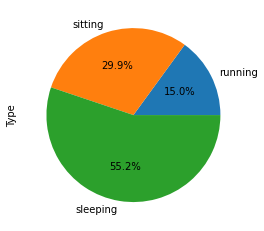

In [5]:
print(imbalance_dataset["status"].value_counts())

imbalance_dataset.groupby('status').size().plot(kind='pie',
                                       y = "status",
                                       label = "Type",
                                       autopct='%1.1f%%')

In [6]:
running = imbalance_dataset[imbalance_dataset["status"] == "running"]
sitting  = imbalance_dataset[imbalance_dataset["status"] == "sitting"]
sleeping = imbalance_dataset[imbalance_dataset["status"] == "sleeping"]
print(running .shape)
print(sitting.shape)
print(sleeping.shape)

(190, 3)
(379, 3)
(700, 3)


In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(imbalance_dataset ['status'])

In [8]:
imbalance_dataset['status'] = imbalance_dataset['status'].map({'running': 0, 'sitting': 1, 'sleeping': 2})
imbalance_dataset.head()

,name,status,keypoints
0,Image_1.jpg,1,[[[[0.33364123 0.37497622 0.7457769 ]\r\n [0...
1,Image_10005.jpg,1,[[[[0.21137007 0.30594978 0.3183812 ]\r\n [0...
2,Image_10012.jpg,1,[[[[0.52972406 0.59848297 0.64693785]\r\n [0...
3,Image_1002.jpg,2,[[[[0.40297922 0.48212966 0.23498732]\r\n [0...
4,Image_10026.jpg,1,[[[[0.33772936 0.5081584 0.91255295]\r\n [0...


In [9]:
y = imbalance_dataset[['status']]

In [10]:
from imblearn.over_sampling import SMOTE

su = SMOTE(random_state=40)
X_su, y_su = su.fit_resample(X, y)

1    700
2    700
0    700
Name: status, dtype: int64


<AxesSubplot:ylabel='Type'>

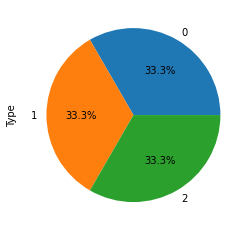

In [11]:
print(y_su["status"].value_counts())

y_su.groupby('status').size().plot(kind='pie',
                                       y = "status",
                                       label = "Type",
                                       autopct='%1.1f%%')
                                       

In [13]:
y_su.to_csv('D:/Task/balanced_keypoints.csv', index=False)